<a href="https://colab.research.google.com/github/veydantkatyal/Curvetopia/blob/main/Curvetopia_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INSTALLATION**

In [ ]:
!pip install streamlit pandas


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **DATA PREPARATION**

In [ ]:
%%writefile data_preparation.py
import xml.etree.ElementTree as ET
import numpy as np
import os

def parse_svg(svg_path):
    """
    Parse an SVG file and extract elements of interest.
    """
    tree = ET.parse(svg_path)
    root = tree.getroot()

    elements = []
    for elem in root.iter():
        element_data = {
            'tag': elem.tag.split('}')[-1],  # Remove namespace
            'attributes': elem.attrib,
            'text': elem.text
        }
        elements.append(element_data)

    return elements

def extract_features(parsed_svg):
    """
    Extract simple features from parsed SVG data.
    """
    features = []

    for elem in parsed_svg:
        if elem['tag'] == 'rect':
            features.extend([
                float(elem['attributes'].get('x', 0)),
                float(elem['attributes'].get('y', 0)),
                float(elem['attributes'].get('width', 0)),
                float(elem['attributes'].get('height', 0))
            ])
        elif elem['tag'] == 'circle':
            features.extend([
                float(elem['attributes'].get('cx', 0)),
                float(elem['attributes'].get('cy', 0)),
                float(elem['attributes'].get('r', 0))
            ])
        # Add more shapes as needed

    # Zero-pad features to ensure consistent length
    max_length = 10  # Adjust based on expected maximum number of features
    features.extend([0] * (max_length - len(features)))

    return np.array(features)

def create_dataset(input_dir, output_dir):
    """
    Create a dataset from pairs of input and output SVGs.
    """
    dataset = []

    for input_file in os.listdir(input_dir):
        if input_file.endswith('.svg'):
            input_path = os.path.join(input_dir, input_file)
            output_file = input_file.replace('.svg', '_sol.svg')  # Adjust naming convention if needed
            output_path = os.path.join(output_dir, output_file)

            if os.path.exists(output_path):
                input_elements = parse_svg(input_path)
                output_elements = parse_svg(output_path)

                input_features = extract_features(input_elements)
                output_features = extract_features(output_elements)

                dataset.append((input_features, output_features))

    return dataset

# Example usage:
input_dir = '/content/drive/MyDrive/input_svgs/'  # Path to your input SVGs in Google Drive
output_dir = '/content/drive/MyDrive/output_svgs/'  # Path to your output SVGs in Google Drive

dataset = create_dataset(input_dir, output_dir)


Overwriting data_preparation.py


In [ ]:
!python data_preparation.py

# **TRAINING DATA**

In [ ]:
%%writefile train_data.py
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib
from data_preparation import create_dataset  # Import the function to create the dataset

# Create the dataset
input_dir = '/content/drive/MyDrive/input_svgs/'  # Path to your input SVGs in Google Drive
output_dir = '/content/drive/MyDrive/output_svgs/'  # Path to your output SVGs in Google Drive
dataset = create_dataset(input_dir, output_dir)

# Convert the dataset into numpy arrays for ML training
X = np.array([item[0] for item in dataset])  # Input features
y = np.array([item[1] for item in dataset])  # Output features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Random Forest Mean Squared Error: {mse}')

# Fine-tune the Random Forest model using GridSearchCV with KFold cross-validation (n_splits=2)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

kf = KFold(n_splits=2, shuffle=True, random_state=42)

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
joblib.dump(best_model, '/content/best_model.pkl')

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Best Model Mean Squared Error: {mse}')


Overwriting train_data.py


In [ ]:
!python train_data.py

Random Forest Mean Squared Error: 4014.9445987500003
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Model Mean Squared Error: 4003.653048149999


In [ ]:
!pip install cairosvg pillow matplotlib


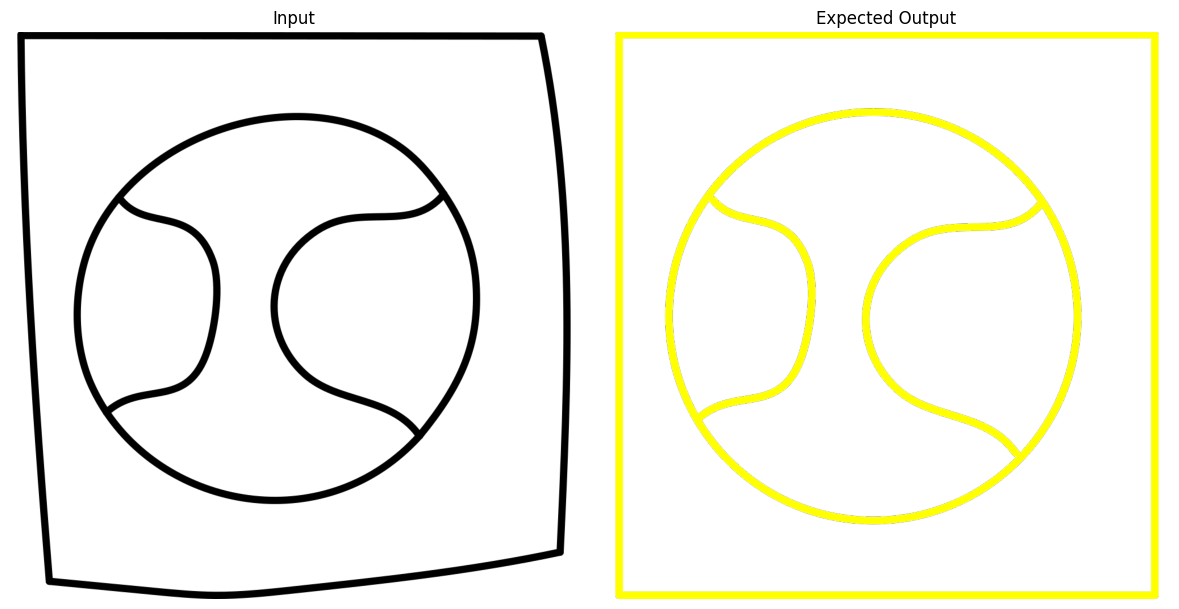

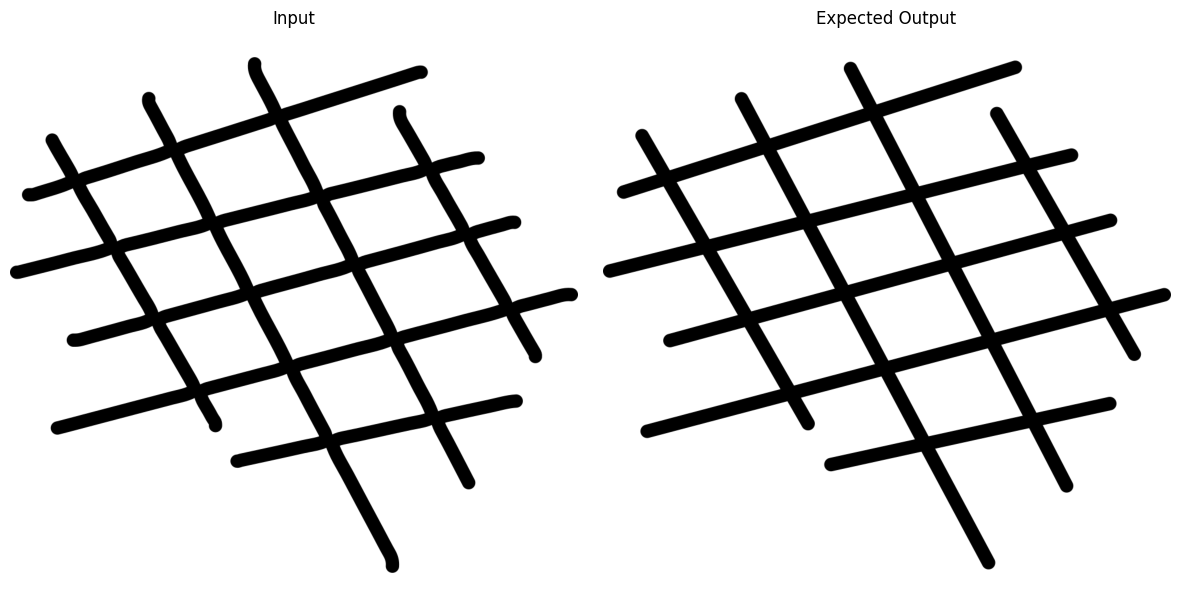

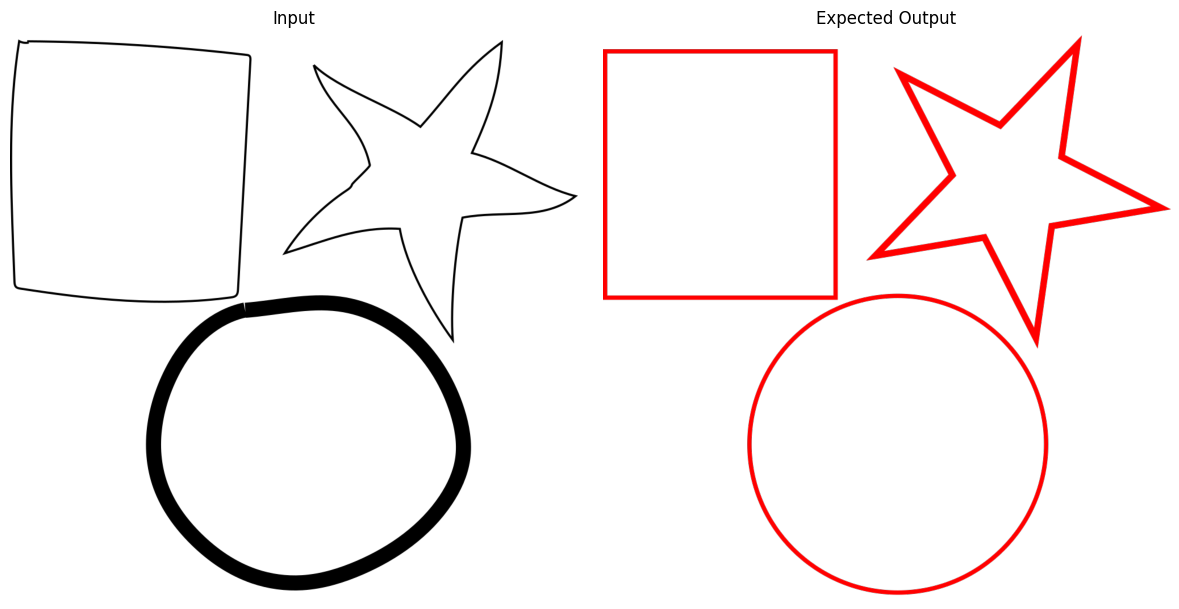

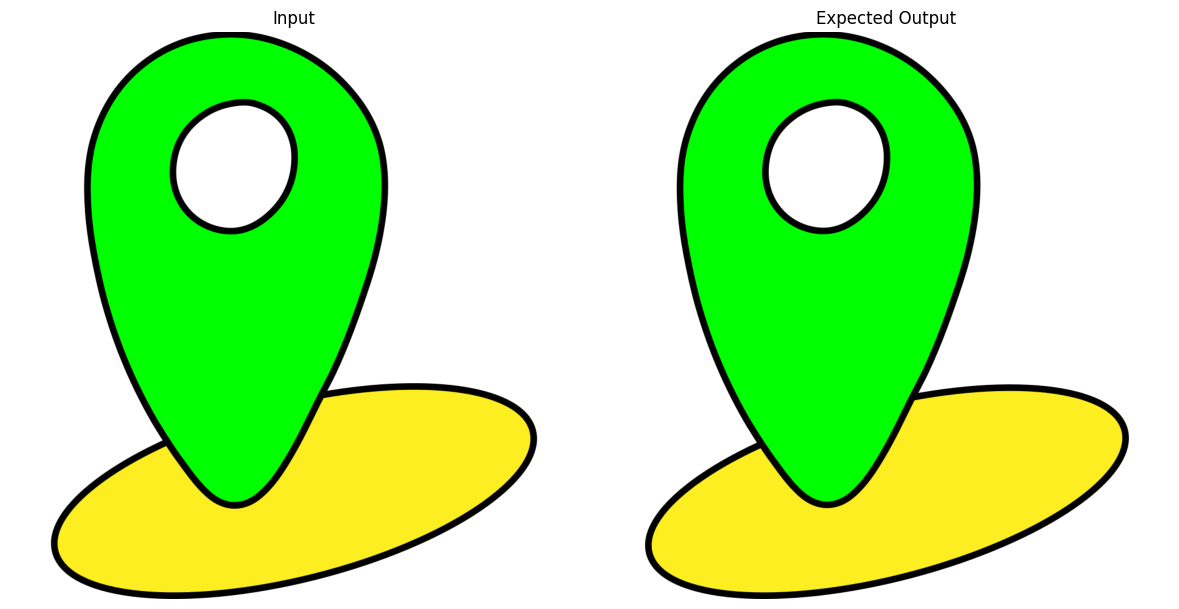

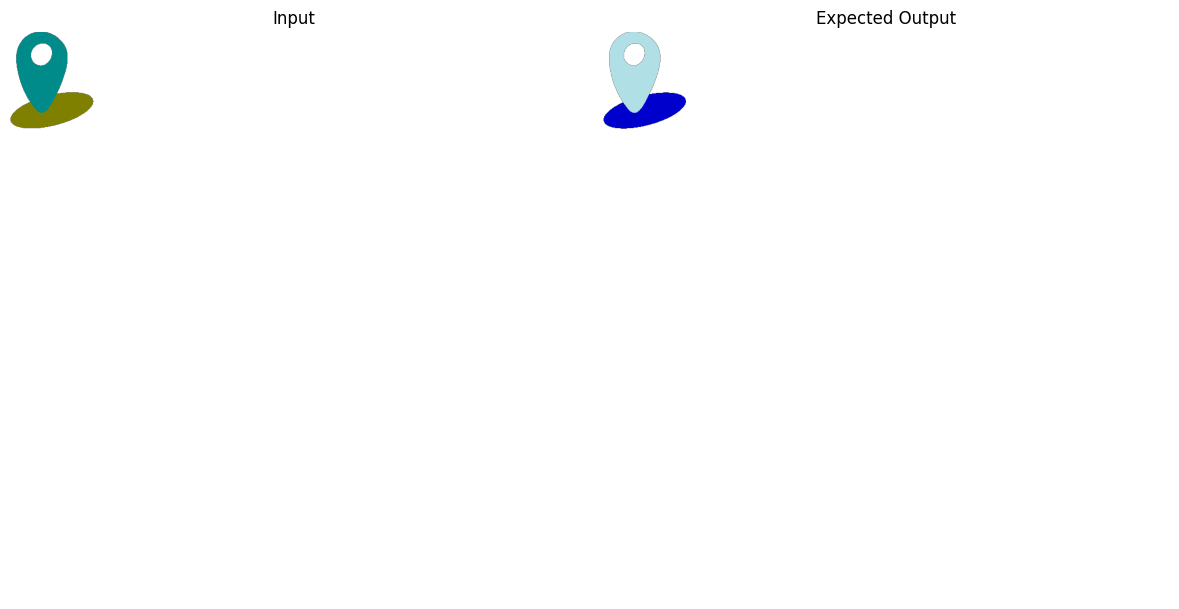

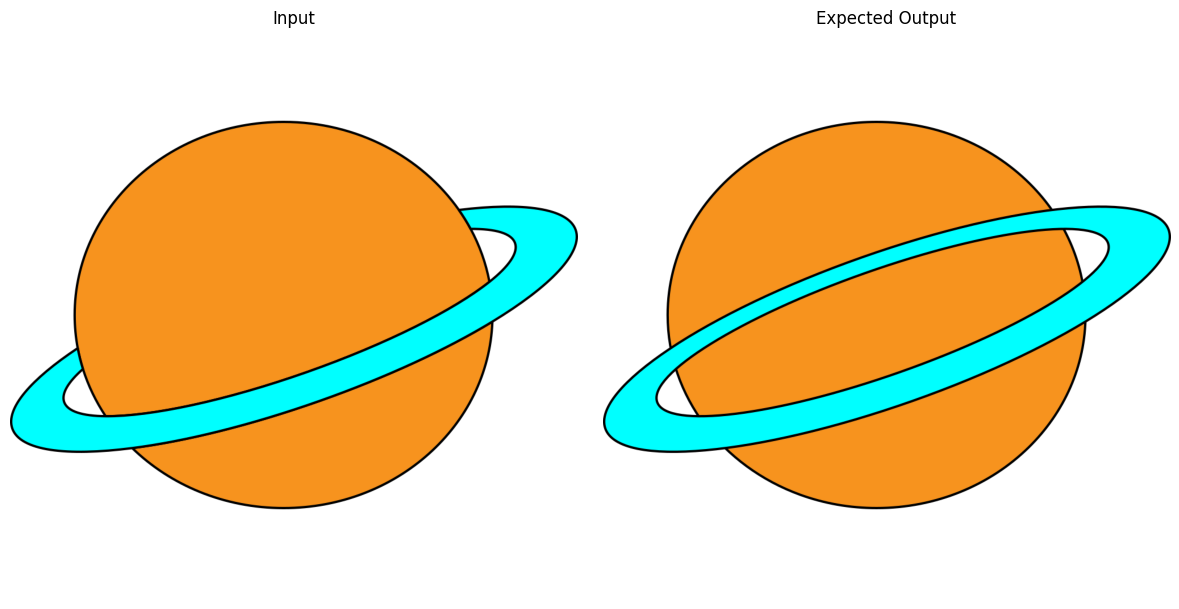

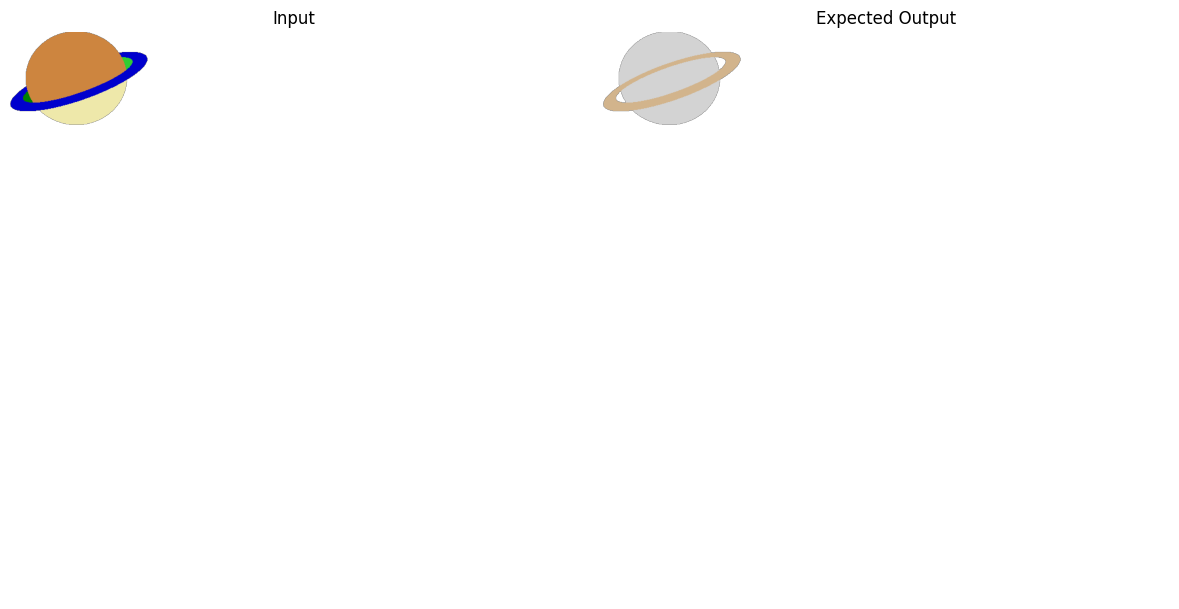

In [ ]:
import os
import cairosvg
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from PIL import Image

def add_default_svg_size(svg_path, output_path, default_width="1000px", default_height="1000px"):
    """
    Ensure the SVG has a defined width and height. If not, add default dimensions.
    """
    tree = ET.parse(svg_path)
    root = tree.getroot()

    # Set width and height if they don't exist
    if 'width' not in root.attrib:
        root.attrib['width'] = default_width
    if 'height' not in root.attrib:
        root.attrib['height'] = default_height

    # Sometimes SVGs use a viewBox instead of width and height
    if 'viewBox' not in root.attrib:
        root.attrib['viewBox'] = f"0 0 {default_width[:-2]} {default_height[:-2]}"

    tree.write(output_path)

def convert_svg_to_png(svg_path, png_path):
    """
    Convert an SVG file to PNG format using CairoSVG.
    """
    cairosvg.svg2png(url=svg_path, write_to=png_path)

def display_pngs_side_by_side(input_png_path, output_png_path):
    """
    Display two PNG files side by side using matplotlib.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the input PNG
    input_img = Image.open(input_png_path)
    axes[0].imshow(input_img)
    axes[0].set_title("Input")
    axes[0].axis('off')

    # Display the expected output PNG, if it exists
    if os.path.exists(output_png_path):
        output_img = Image.open(output_png_path)
        axes[1].imshow(output_img)
        axes[1].set_title("Expected Output")
    else:
        axes[1].set_title("Expected Output PNG (Not Found)")
        axes[1].text(0.5, 0.5, "File Not Found", ha="center", va="center", fontsize=12)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
def main():
    input_dir = '/content/drive/MyDrive/input_svgs/'  # Path to your input SVGs in Google Drive
    output_dir = '/content/drive/MyDrive/output_svgs/'  # Path to your output SVGs in Google Drive
    output_png_dir = '/content/output_pngs/'  # Directory to save converted PNGs

    os.makedirs(output_png_dir, exist_ok=True)

    # List the input SVG files
    input_files = sorted([f for f in os.listdir(input_dir) if f.endswith('.svg')])

    for input_file in input_files:
        input_path = os.path.join(input_dir, input_file)
        temp_svg_path = os.path.join(output_png_dir, input_file)  # Temporary SVG with size added
        output_file = input_file.replace('.svg', '_sol.svg')
        output_path = os.path.join(output_dir, output_file)

        # Ensure SVG has size attributes
        add_default_svg_size(input_path, temp_svg_path)

        # Convert SVG to PNG
        input_png_path = os.path.join(output_png_dir, input_file.replace('.svg', '.png'))
        output_png_path = os.path.join(output_png_dir, output_file.replace('.svg', '.png'))

        convert_svg_to_png(temp_svg_path, input_png_path)

        if os.path.exists(output_path):
            add_default_svg_size(output_path, temp_svg_path)  # Ensure size for the output SVG
            convert_svg_to_png(temp_svg_path, output_png_path)

        # Display the input and expected output PNGs side by side
        display_pngs_side_by_side(input_png_path, output_png_path)

if __name__ == "__main__":
    main()
